In [3]:
# Import Libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F

In [4]:
# Device configuration check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [5]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.RandomRotation(15),  # Randomly rotate the image by +/- 15 degrees
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transform
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(), #converts numpy nd arrays to pytorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing with mean and std deviation
])

In [6]:
# MNIST Dataset with normalization
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,  # Use the transform with normalization
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform  # Use the same transform for consistency
)

In [7]:
# Splitting training data into train and validation sets
validation_size = 10000
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])

In [8]:
# Define the data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [1]:
# Define CNN architectures
class CNN1(nn.Module):
    def __init__(self): 
        super(CNN1, self).__init__() 
        self.conv1 = nn.Sequential( 
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

NameError: name 'nn' is not defined

In [10]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),
        )
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.4)  # Slightly reduce dropout rate
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

In [90]:
# Training and validation function
def train_and_validate(num_epochs, cnn, loaders, optimizer, loss_func, device):
    cnn.train()
    training_stats = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training Phase
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in loaders['train']:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
        # Validation Phase
        val_loss, val_correct, val_total = 0, 0, 0
        cnn.eval()
        with torch.no_grad():
            for images, labels in loaders['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn(images)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss per epoch
        training_stats['train_loss'].append(train_loss / len(loaders['train']))
        training_stats['train_acc'].append(100 * train_correct / train_total)
        training_stats['val_loss'].append(val_loss / len(loaders['val']))
        training_stats['val_acc'].append(100 * val_correct / val_total)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {training_stats["train_loss"][-1]:.4f}, '
              f'Train Accuracy: {training_stats["train_acc"][-1]:.2f}%, '
              f'Val Loss: {training_stats["val_loss"][-1]:.4f}, '
              f'Val Accuracy: {training_stats["val_acc"][-1]:.2f}%')

    return training_stats
    
# Train, validate, and save CNN1
cnn1 = CNN1().to(device)
optimizer1 = optim.Adam(cnn1.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
print("Training CNN1")
training_stats1 = train_and_validate(10, cnn1, loaders, optimizer1, loss_func, device)


Training CNN1
Epoch 1/10, Train Loss: 0.4018, Train Accuracy: 87.58%, Val Loss: 0.1939, Val Accuracy: 94.19%
Epoch 2/10, Train Loss: 0.1631, Train Accuracy: 95.04%, Val Loss: 0.1529, Val Accuracy: 95.32%
Epoch 3/10, Train Loss: 0.1287, Train Accuracy: 95.99%, Val Loss: 0.1251, Val Accuracy: 96.11%
Epoch 4/10, Train Loss: 0.1132, Train Accuracy: 96.57%, Val Loss: 0.1096, Val Accuracy: 96.77%
Epoch 5/10, Train Loss: 0.1010, Train Accuracy: 96.83%, Val Loss: 0.1226, Val Accuracy: 96.34%
Epoch 6/10, Train Loss: 0.0919, Train Accuracy: 97.19%, Val Loss: 0.1073, Val Accuracy: 96.82%
Epoch 7/10, Train Loss: 0.0875, Train Accuracy: 97.35%, Val Loss: 0.0956, Val Accuracy: 97.02%
Epoch 8/10, Train Loss: 0.0846, Train Accuracy: 97.24%, Val Loss: 0.0826, Val Accuracy: 97.51%
Epoch 9/10, Train Loss: 0.0798, Train Accuracy: 97.40%, Val Loss: 0.1001, Val Accuracy: 96.89%
Epoch 10/10, Train Loss: 0.0771, Train Accuracy: 97.57%, Val Loss: 0.0788, Val Accuracy: 97.44%


In [92]:
# Training and validation function
def train_and_validate(num_epochs, cnn, loaders, optimizer, loss_func, device):
    cnn.train()
    training_stats = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training Phase
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in loaders['train']:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
        # Validation Phase
        val_loss, val_correct, val_total = 0, 0, 0
        cnn.eval()
        with torch.no_grad():
            for images, labels in loaders['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn(images)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss per epoch
        training_stats['train_loss'].append(train_loss / len(loaders['train']))
        training_stats['train_acc'].append(100 * train_correct / train_total)
        training_stats['val_loss'].append(val_loss / len(loaders['val']))
        training_stats['val_acc'].append(100 * val_correct / val_total)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {training_stats["train_loss"][-1]:.4f}, '
              f'Train Accuracy: {training_stats["train_acc"][-1]:.2f}%, '
              f'Val Loss: {training_stats["val_loss"][-1]:.4f}, '
              f'Val Accuracy: {training_stats["val_acc"][-1]:.2f}%')

    return training_stats

# Train, validate, and save CNN2
cnn2 = CNN2().to(device)
optimizer2 = optim.Adam(cnn2.parameters(), lr=0.001)
print("Training CNN2")
training_stats2 = train_and_validate(10, cnn2, loaders, optimizer2, loss_func, device)

Training CNN2
Epoch 1/10, Train Loss: 0.2346, Train Accuracy: 92.78%, Val Loss: 0.1104, Val Accuracy: 96.48%
Epoch 2/10, Train Loss: 0.1072, Train Accuracy: 96.68%, Val Loss: 0.0906, Val Accuracy: 97.22%
Epoch 3/10, Train Loss: 0.0851, Train Accuracy: 97.34%, Val Loss: 0.0854, Val Accuracy: 97.52%
Epoch 4/10, Train Loss: 0.0816, Train Accuracy: 97.40%, Val Loss: 0.0771, Val Accuracy: 97.54%
Epoch 5/10, Train Loss: 0.0707, Train Accuracy: 97.83%, Val Loss: 0.0742, Val Accuracy: 97.66%
Epoch 6/10, Train Loss: 0.0656, Train Accuracy: 97.94%, Val Loss: 0.0694, Val Accuracy: 98.01%
Epoch 7/10, Train Loss: 0.0611, Train Accuracy: 98.09%, Val Loss: 0.0658, Val Accuracy: 98.02%
Epoch 8/10, Train Loss: 0.0619, Train Accuracy: 98.14%, Val Loss: 0.0843, Val Accuracy: 97.81%
Epoch 9/10, Train Loss: 0.0593, Train Accuracy: 98.21%, Val Loss: 0.0673, Val Accuracy: 97.96%
Epoch 10/10, Train Loss: 0.0569, Train Accuracy: 98.30%, Val Loss: 0.0774, Val Accuracy: 97.72%


In [93]:
torch.save(cnn1.state_dict(), "cnn1model.pth")

In [94]:
torch.save(cnn2.state_dict(), "cnn2model.pth")

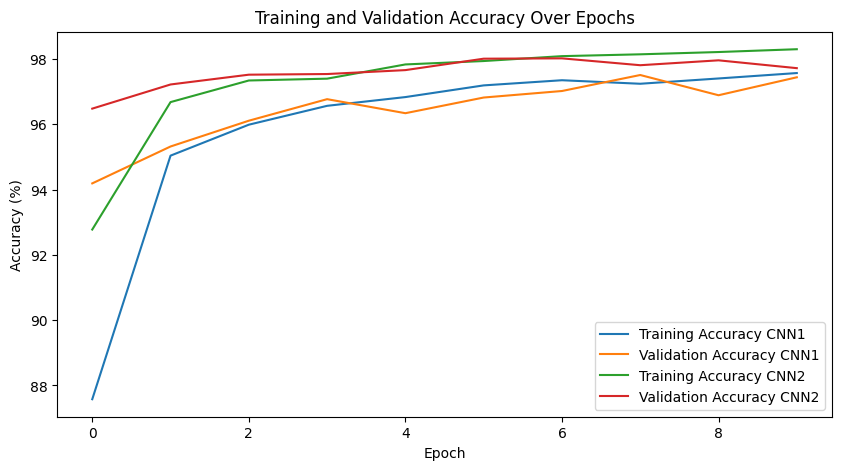

In [95]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_stats1['train_acc'], label='Training Accuracy CNN1')
plt.plot(training_stats1['val_acc'], label='Validation Accuracy CNN1')
plt.plot(training_stats2['train_acc'], label='Training Accuracy CNN2')
plt.plot(training_stats2['val_acc'], label='Validation Accuracy CNN2')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

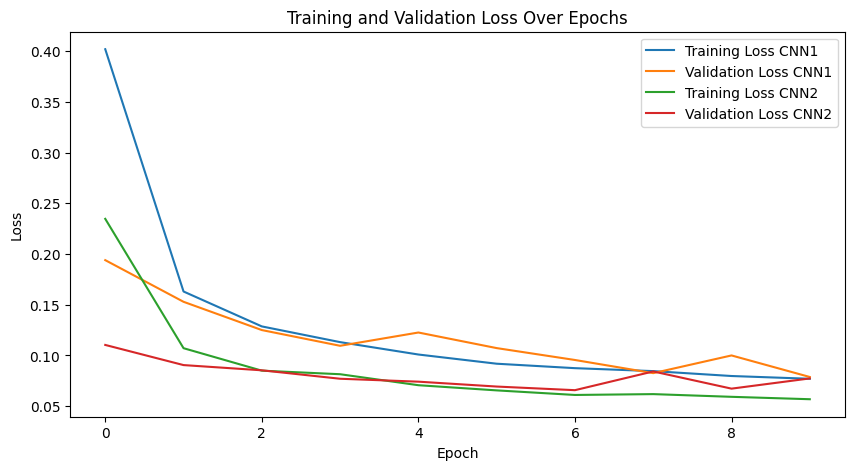

In [96]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_stats1['train_loss'], label='Training Loss CNN1')
plt.plot(training_stats1['val_loss'], label='Validation Loss CNN1')
plt.plot(training_stats2['train_loss'], label='Training Loss CNN2')
plt.plot(training_stats2['val_loss'], label='Validation Loss CNN2')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Load saved models
cnn1 = CNN1().to(device)
cnn1.load_state_dict(torch.load("cnn1model.pth"))
cnn1.eval()

CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [12]:
cnn2 = CNN2().to(device)
cnn2.load_state_dict(torch.load("cnn2model.pth"))
cnn2.eval()

CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
def evaluate_model(cnn, test_loader, device):
    cnn.eval()
    test_loss = 0
    correct = 0
    total = 0
    loss_func = nn.CrossEntropyLoss()
    all_images = []
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_predictions.append(predicted.cpu())

    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy, all_images, all_labels, all_predictions

In [26]:
# Evaluate CNN1 on augmented test set
test_loss1, test_acc1, all_images1, all_labels1, all_predictions1 = evaluate_model(cnn1, test_loader, device)
print(f'Test Loss CNN1: {test_loss1:.4f}, Test Accuracy CNN1: {test_acc1:.2f}%')

Test Loss CNN1: 0.0010, Test Accuracy CNN1: 97.83%


In [27]:
# Evaluate CNN2 on augmented test set
test_loss2, test_acc2, all_images2, all_labels2, all_predictions2 = evaluate_model(cnn2, test_loader, device)
print(f'Test Loss CNN2: {test_loss2:.4f}, Test Accuracy CNN2: {test_acc2:.2f}%')

Test Loss CNN2: 0.0008, Test Accuracy CNN2: 98.21%


In [28]:
import random

def plot_comparison(images, labels, predictions, title):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axs.flatten()):
        index = random.randint(0, len(images) - 1)
        img = images[index].squeeze().numpy()
        label = labels[index].item()
        prediction = predictions[index].item()
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {label}, Predicted: {prediction}')
        ax.axis('off')
    
    plt.show()

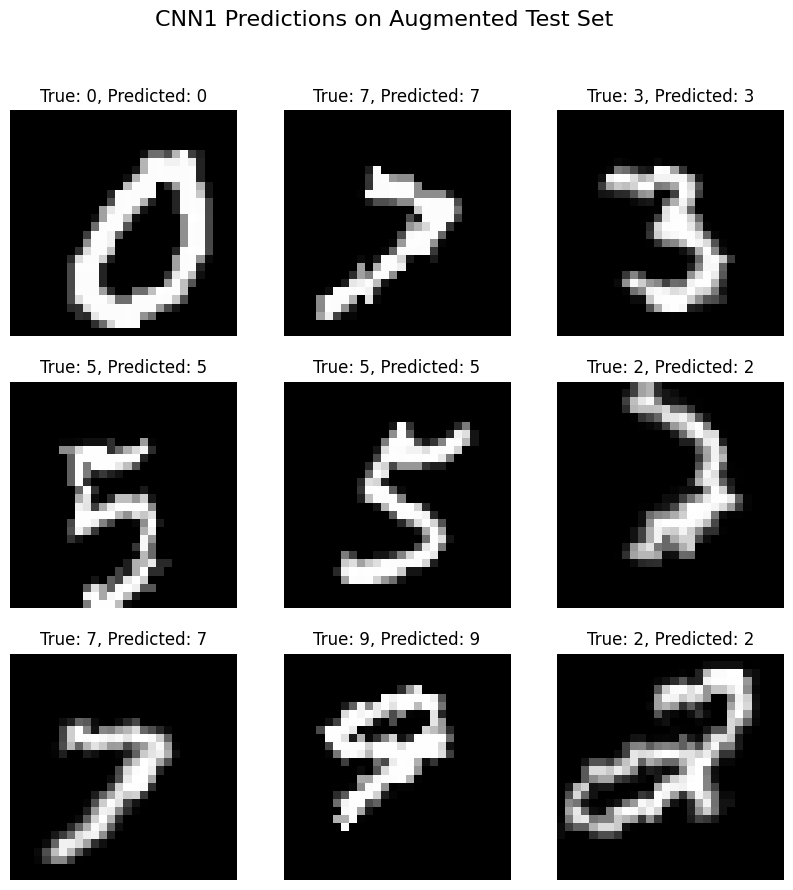

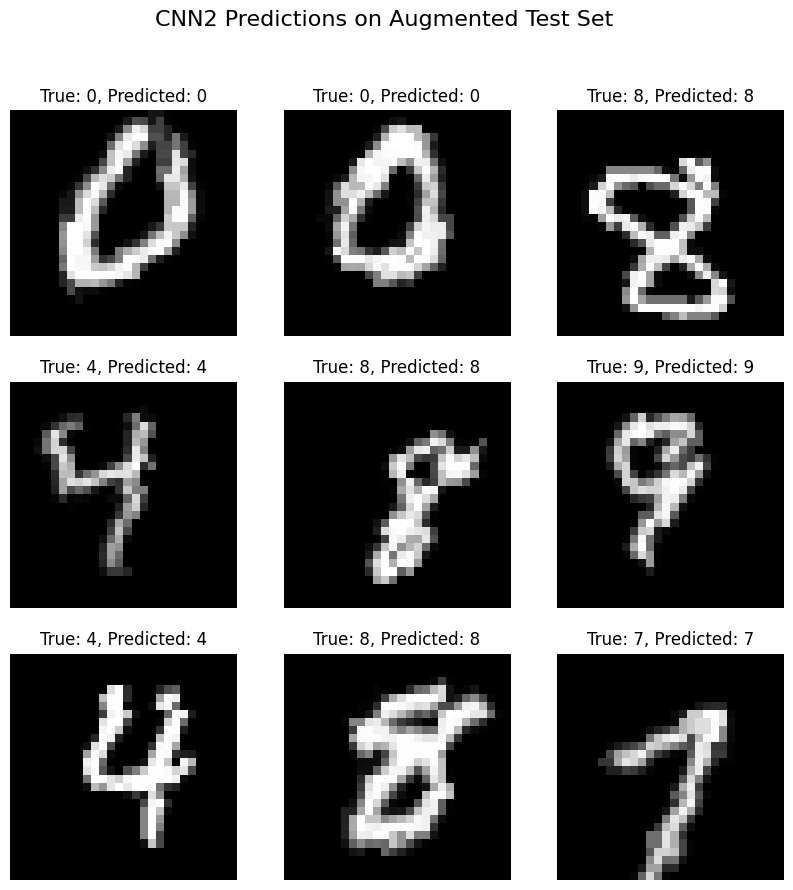

In [29]:
# Flatten all batches into a single list
all_images1 = torch.cat(all_images1)
all_labels1 = torch.cat(all_labels1)
all_predictions1 = torch.cat(all_predictions1)

all_images2 = torch.cat(all_images2)
all_labels2 = torch.cat(all_labels2)
all_predictions2 = torch.cat(all_predictions2)

# Plot comparison for CNN1
plot_comparison(all_images1, all_labels1, all_predictions1, 'CNN1 Predictions on Augmented Test Set')

# Plot comparison for CNN2
plot_comparison(all_images2, all_labels2, all_predictions2, 'CNN2 Predictions on Augmented Test Set')


In [99]:
# Image Processing Functions
def preprocess_image(roi):
    # Convert to grayscale if not already
    if roi.ndim == 3 and roi.shape[2] == 3:
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Simple binary thresholding
    _, binary = cv2.threshold(roi, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Display intermediate images for debugging
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(roi, cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('Binary Image')
    plt.show()

    return binary

In [100]:
def resize_and_normalize(digit_img):
    # Resize the image to 28x28 pixels
    resized_img = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_AREA)
    # Convert to a PyTorch tensor and scale to [0, 1]
    tensor_img = torch.tensor(resized_img, dtype=torch.float32) / 255.0
    # Normalize using the predefined mean and std deviation
    mean = 0.1307
    std = 0.3081
    normalized_img = (tensor_img - mean) / std
    # Add batch and channel dimensions
    normalized_img = normalized_img.unsqueeze(0).unsqueeze(0)
    return normalized_img

In [101]:
def find_and_draw_contours(binary, roi, cnn, device):
    # Create a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)  # Adjust the size of the kernel as needed
    
    # Perform dilation multiple times to increase thickness
    binary = cv2.dilate(binary, kernel, iterations=3)  # Increase iterations for more thickness

    #Optionally, perform erosion to clean up noise
    binary = cv2.erode(binary, kernel, iterations=1)
    
    # Find contours on the dilated binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 20:  # Adjust contour sizes based on your expected digit sizes
            digit = binary[y:y+h, x:x+w]
            tensor = resize_and_normalize(digit)
            tensor = tensor.to(device)
            output = cnn(tensor)
            pred = output.argmax(dim=1).item()
            cv2.rectangle(roi, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(roi, str(pred), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    return roi

In [102]:
# Function to test model with webcam input
def test_model_with_webcam(cnn):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    # Rectangle Size
    rect_start = (70, 100)
    rect_size = (500, 300)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Drawing a rectangle to help guide where to hold the paper
        cv2.rectangle(frame, rect_start, (rect_start[0] + rect_size[0], rect_start[1] + rect_size[1]), (0, 255, 0), 2)
        cv2.imshow('Frame', frame)

        if cv2.waitKey(1) == ord('s'):  # Press 's' to process the current frame
            roi = frame[rect_start[1]:rect_start[1] + rect_size[1], rect_start[0]:rect_start[0] + rect_size[0]]
            binary = preprocess_image(roi)
            plt.imshow(binary, cmap='gray')  # Show the processed binary image
            plt.title("Processed Binary Image")
            plt.show()

            # Finding contours
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                if w > 10 and h > 20:  # Adjust contour sizes based on your expected digit sizes
                    digit = binary[y:y+h, x:x+w]
                    tensor = resize_and_normalize(digit)
                    tensor = tensor.to(device)
                    output = cnn(tensor)
                    pred = output.argmax(dim=1).item()
                    cv2.rectangle(roi, (x, y), (x+w, y+h), (255, 0, 0), 2)
                    cv2.putText(roi, str(pred), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            cv2.imshow('Processed', roi)

        if cv2.waitKey(1) == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    cv2.destroyAllWindows()

Testing CNN1 with webcam input


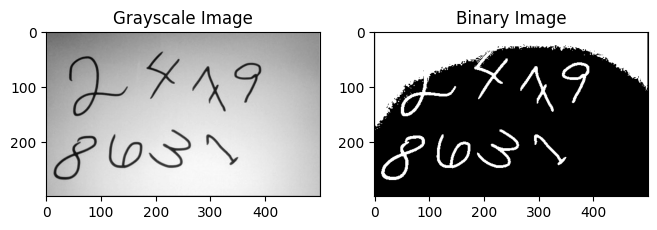

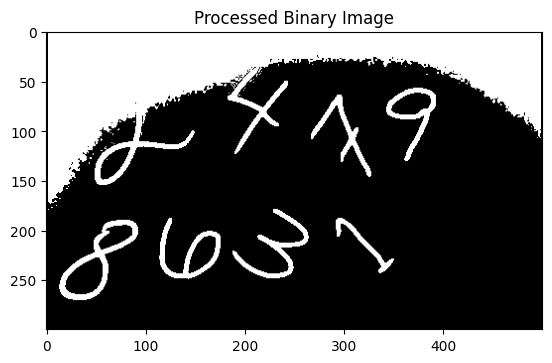

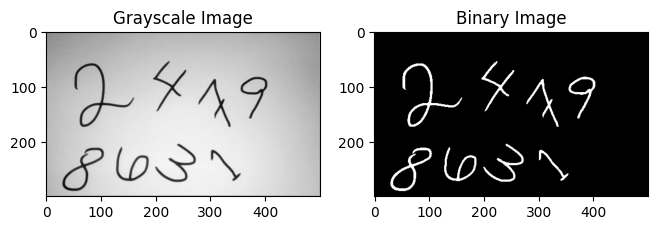

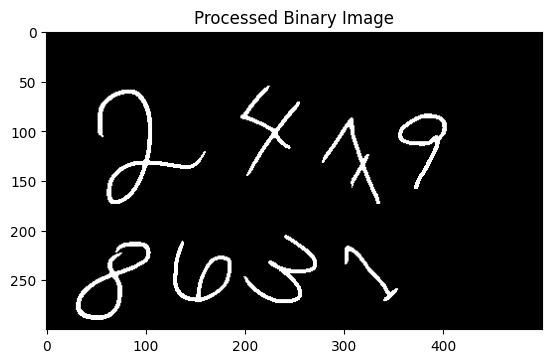

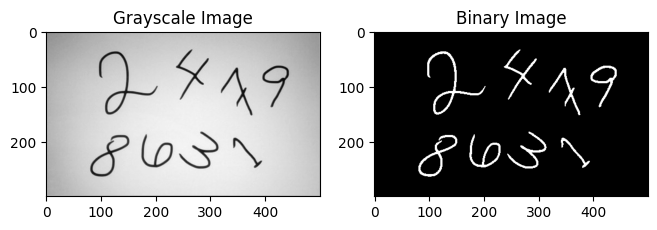

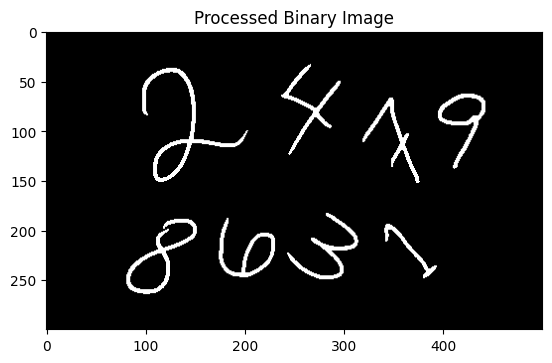

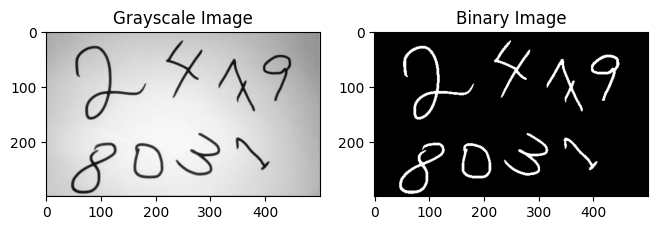

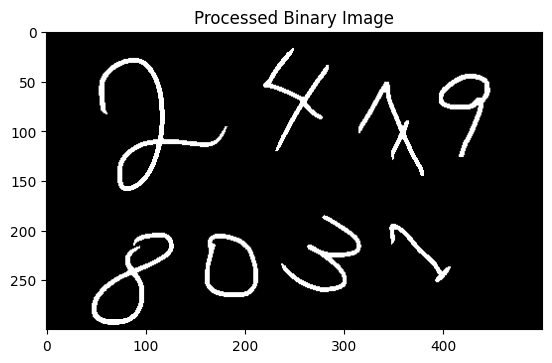

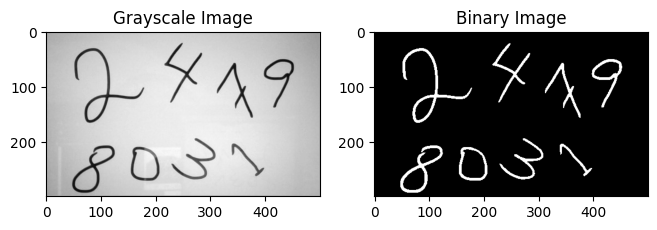

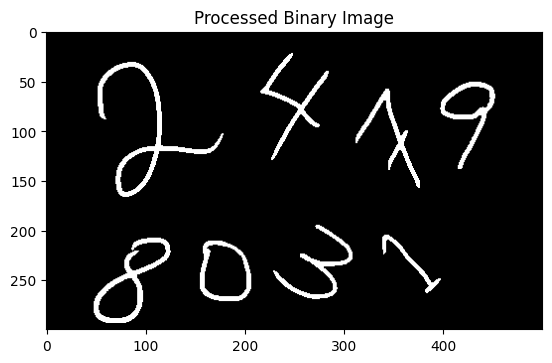

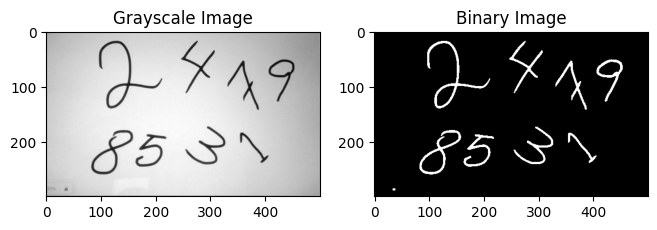

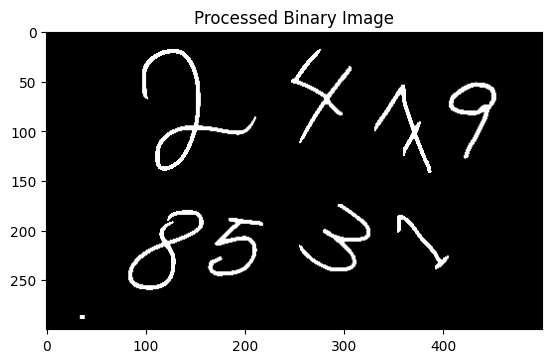

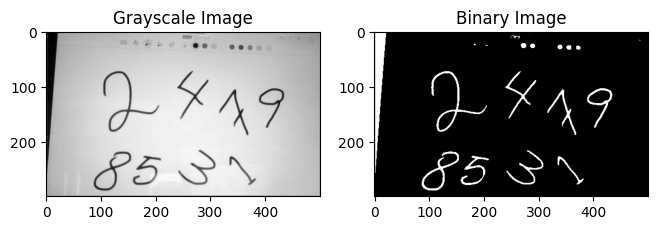

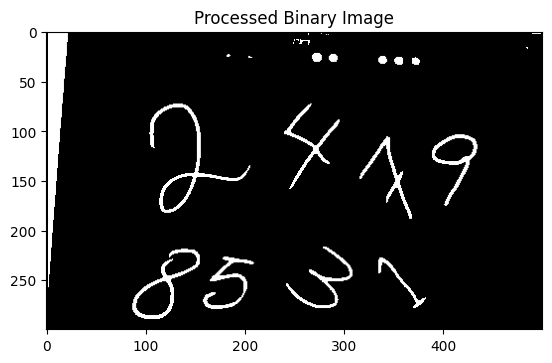

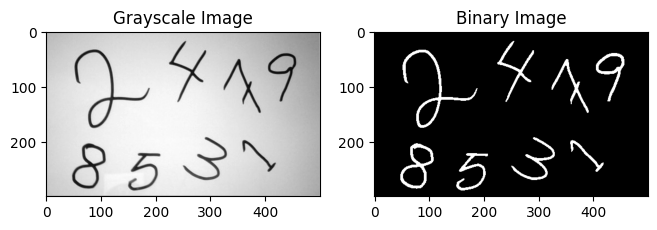

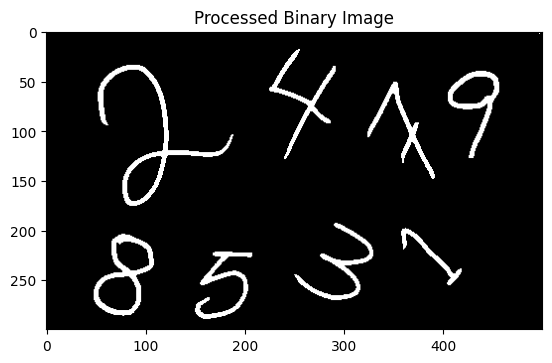

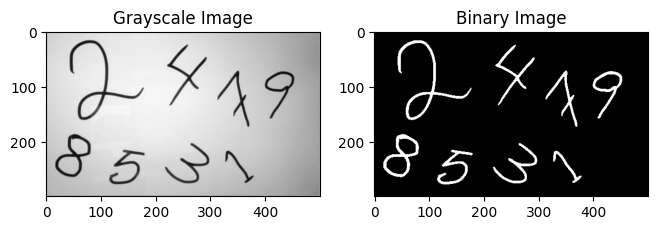

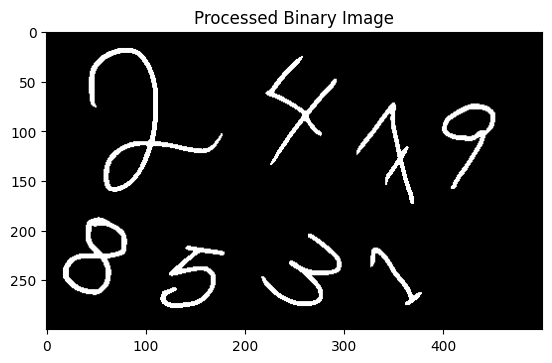

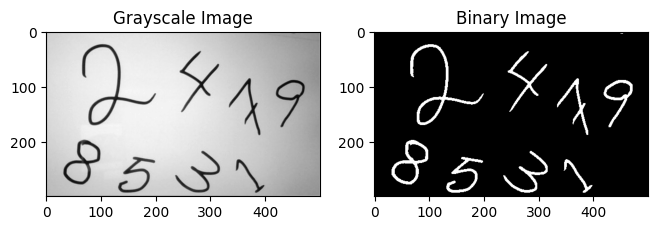

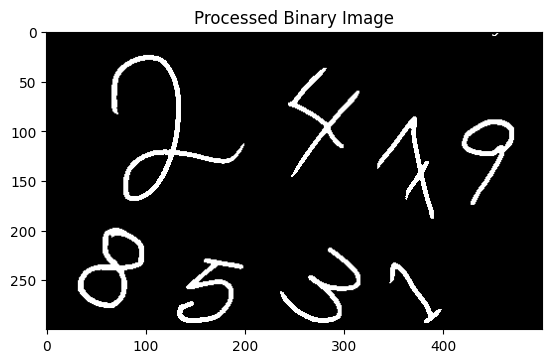

In [103]:
# Test CNN1 model with webcam input
print("Testing CNN1 with webcam input")
test_model_with_webcam(cnn1)

Testing CNN2 with webcam input


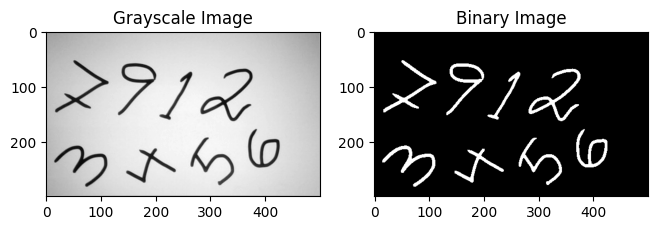

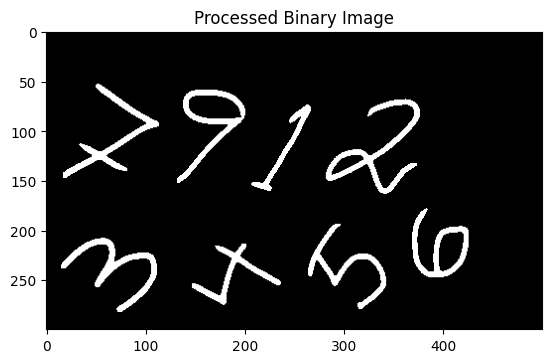

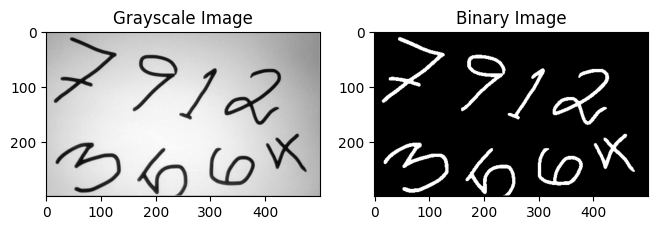

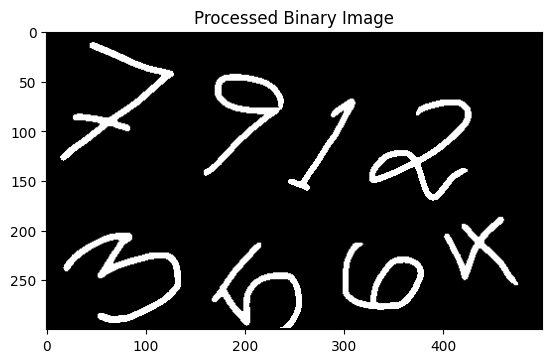

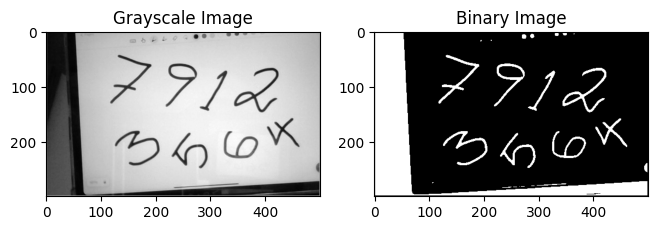

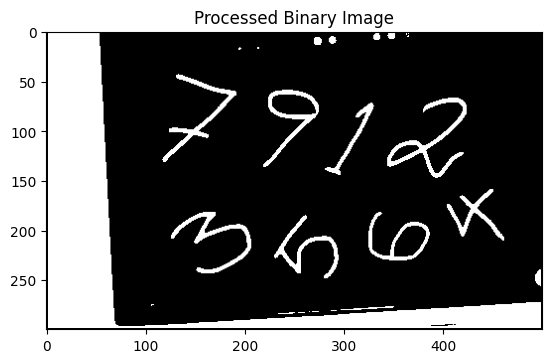

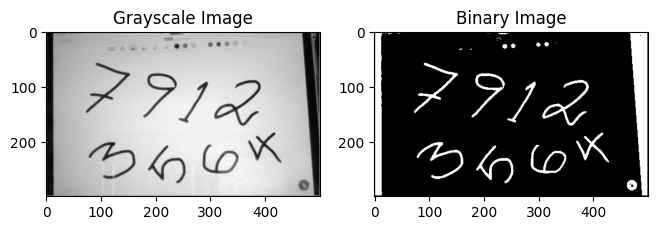

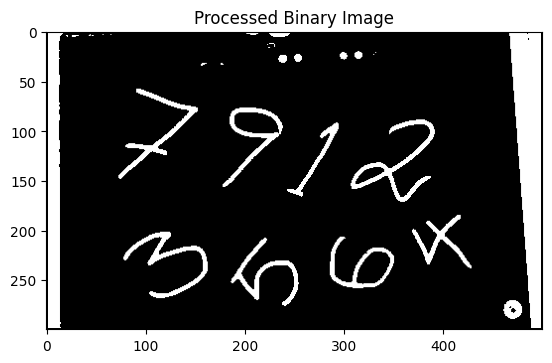

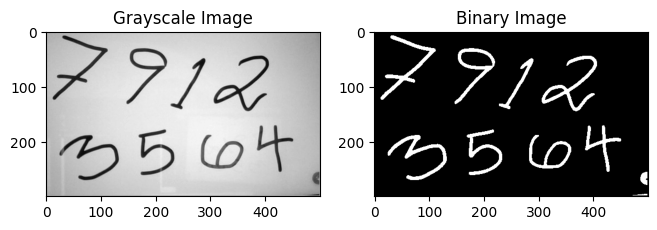

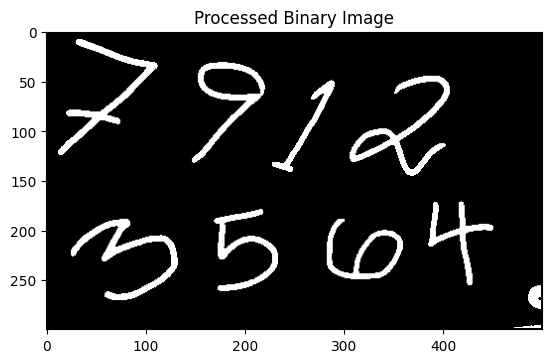

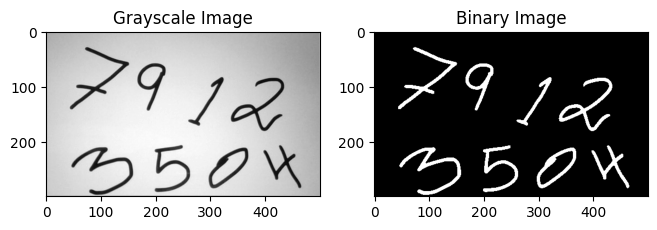

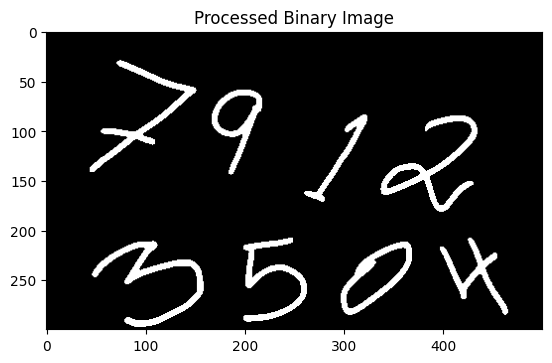

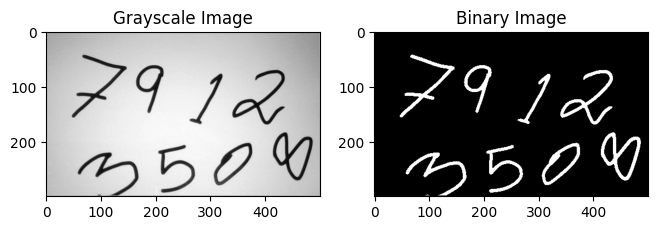

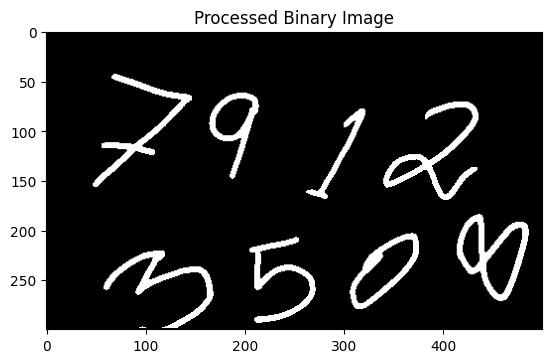

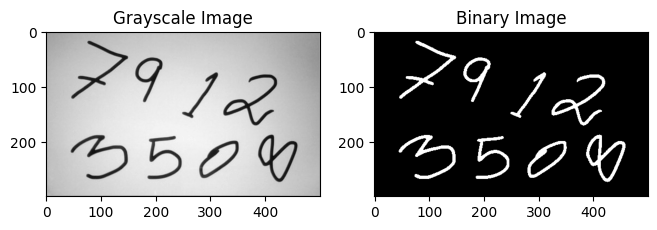

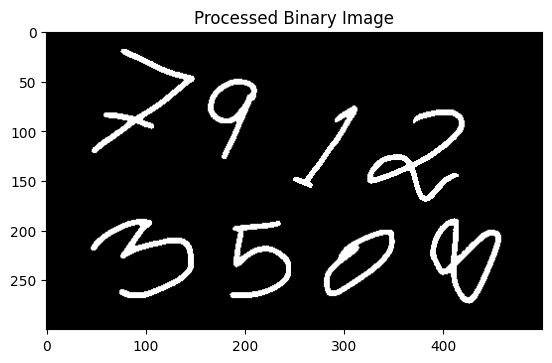

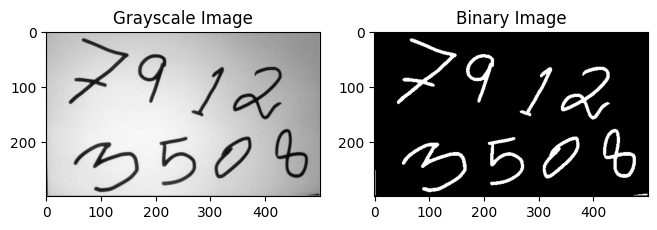

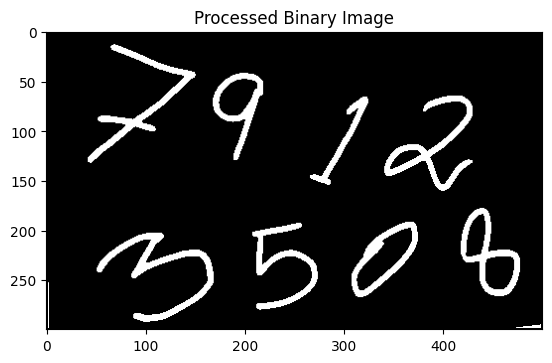

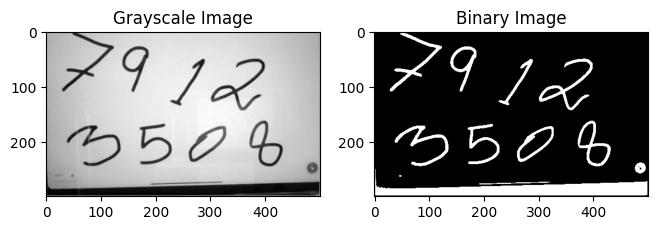

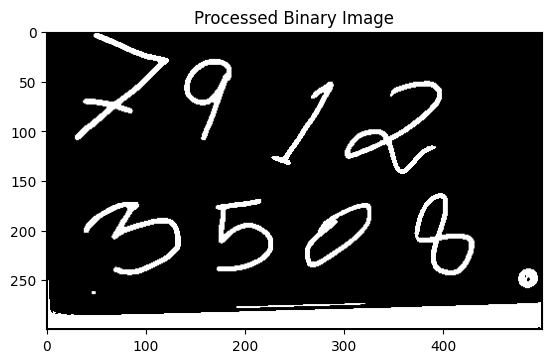

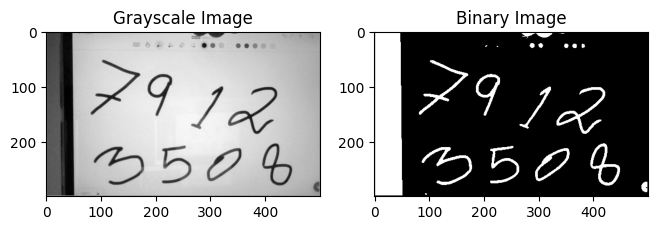

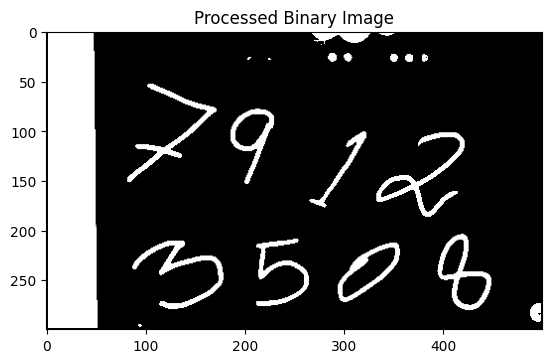

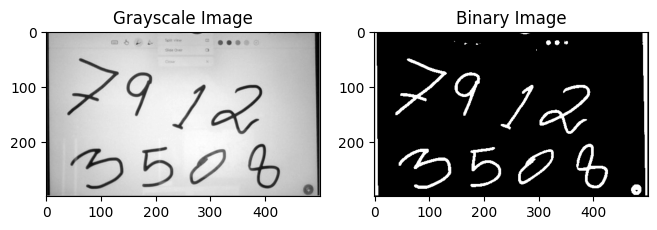

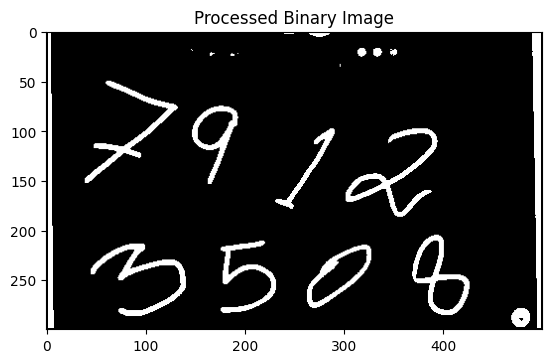

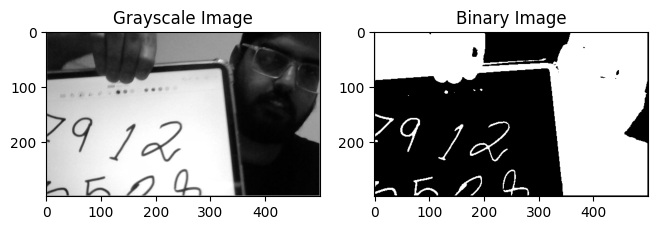

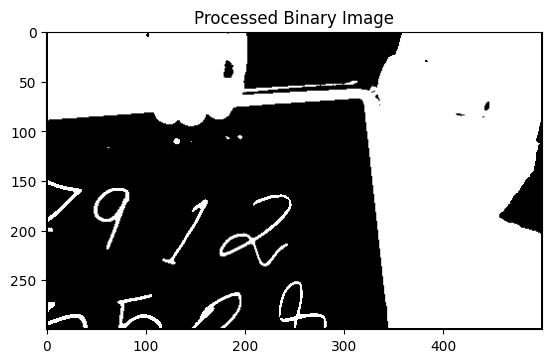

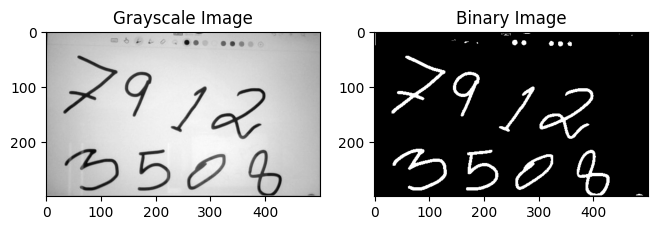

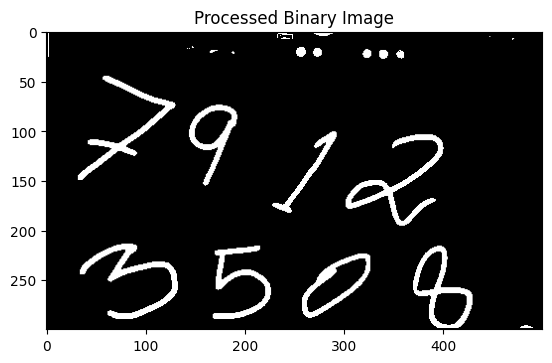

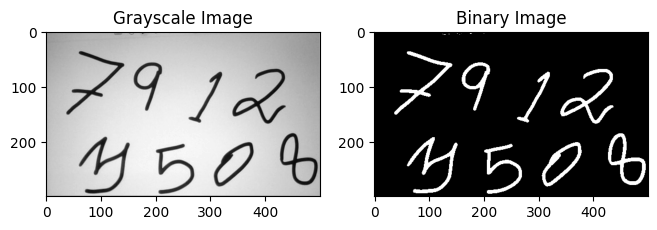

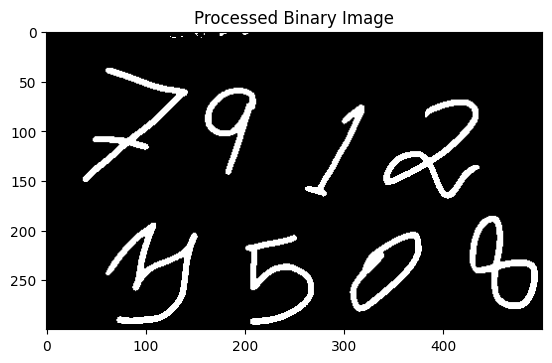

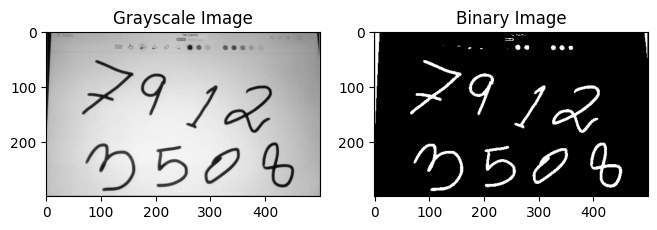

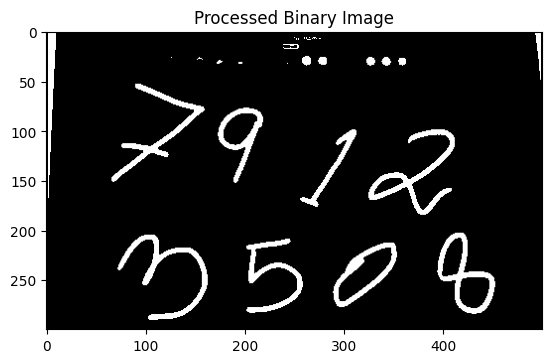

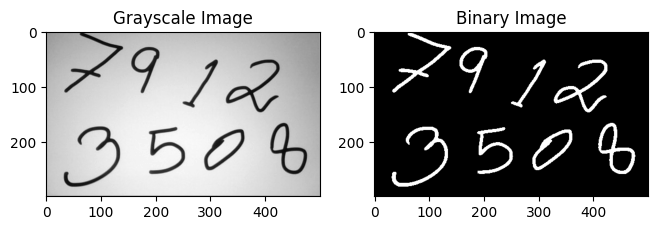

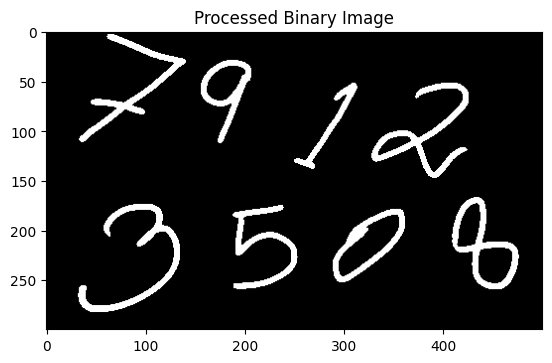

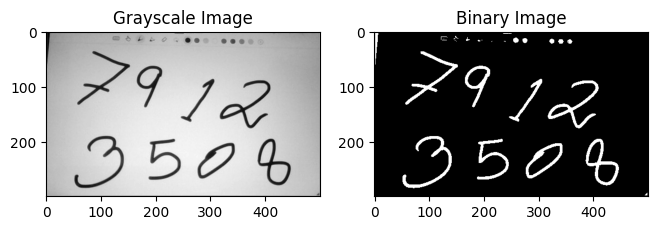

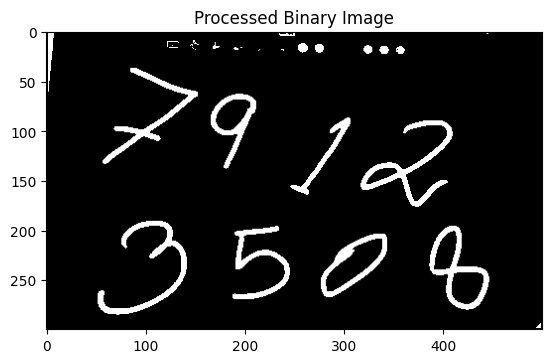

In [104]:
# Test CNN2 model with webcam input
print("Testing CNN2 with webcam input")
test_model_with_webcam(cnn2)